In [25]:
import nni
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader
from nni.nas.hub.pytorch import DARTS as DartsSpace

CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])
valid_data = nni.trace(CIFAR10)(root='./data', train=False, download=True, transform=transform_valid)
valid_loader = DataLoader(valid_data, batch_size=256, num_workers=6)

Defining the darts search space and strategy ( Determine the cells structure )

In [26]:
model_space = DartsSpace(
    width=16,           # the initial filters (channel number) for the model
    num_cells=8,        # the number of stacked cells in total
    dataset='cifar'     # to give a hint about input resolution, here is 32x32
)

In [27]:
fast_dev_run = False

In [28]:
import numpy as np
from nni.nas.evaluator.pytorch import Classification
from torch.utils.data import SubsetRandomSampler

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform)

num_samples = len(train_data)
indices = np.random.permutation(num_samples)
split = num_samples // 2

search_train_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[:split]),
)

search_valid_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[split:]),
)

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader,
    max_epochs=10,
    fast_dev_run=True,
    num_classes=10
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [29]:
from nni.nas.strategy import DARTS as DartsStrategy

strategy = DartsStrategy()

In [30]:
from nni.nas.experiment import NasExperiment

experiment = NasExperiment(model_space, evaluator, strategy)
experiment.run()

[2025-04-18 11:26:38] Config is not provided. Will try to infer.
[2025-04-18 11:26:38] Strategy is found to be a one-shot strategy. Setting execution engine to "sequential" and format to "raw".
[2025-04-18 11:26:38] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:38] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:38] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:39] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:39] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:39] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:39] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:26:39] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | training_module | ClassificationModule | 2.0 M  | train
-----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.950     Total estimated model params size (MB)
8031      Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, train_loss=2.440, train_acc=0.0312]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s, train_loss=2.440, train_acc=0.0312]
[2025-04-18 11:26:43] Waiting for models submitted to engine to finish...
[2025-04-18 11:26:43] Experiment is completed.
[2025-04-18 11:26:43] WARNING: `training_service` will be ignored for sequential execution engine.


True

In [31]:
exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

[2025-04-18 11:26:43] Sorted weights in differentiable cell export (normal cell, node 2): [(0.002142794895917177, 0, 'avg_pool_3x3'), (0.0018491949886083603, 1, 'avg_pool_3x3'), (0.0019274872029200196, 0, 'dil_conv_3x3'), (0.0018631271086633205, 0, 'sep_conv_3x3'), (0.001621387549676001, 1, 'dil_conv_3x3'), (0.0009734281338751316, 0, 'sep_conv_5x5'), (0.0003549943503458053, 1, 'dil_conv_5x5'), (0.00034643735853023827, 1, 'skip_connect'), (0.00017654414114076644, 1, 'max_pool_3x3'), (4.420406912686303e-05, 1, 'sep_conv_5x5'), (-0.0002503776631783694, 0, 'max_pool_3x3'), (-0.0005553741939365864, 1, 'sep_conv_3x3'), (-0.0006821832503192127, 0, 'dil_conv_5x5'), (-0.0008099545375443995, 0, 'skip_connect')]
[2025-04-18 11:26:43] Sorted weights in differentiable cell export (normal cell, node 3): [(0.0019581508822739124, 1, 'avg_pool_3x3'), (0.0008572437800467014, 0, 'sep_conv_3x3'), (0.0005765784299001098, 2, 'dil_conv_3x3'), (0.001757943187840283, 1, 'skip_connect'), (0.0007577212527394295,

{'normal/op_2_0': 'avg_pool_3x3',
 'normal/input_2_0': [0],
 'normal/op_2_1': 'avg_pool_3x3',
 'normal/input_2_1': [1],
 'normal/op_3_0': 'avg_pool_3x3',
 'normal/input_3_0': [1],
 'normal/op_3_1': 'sep_conv_3x3',
 'normal/input_3_1': [0],
 'normal/op_4_0': 'dil_conv_5x5',
 'normal/input_4_0': [0],
 'normal/op_4_1': 'sep_conv_5x5',
 'normal/input_4_1': [3],
 'normal/op_5_0': 'sep_conv_3x3',
 'normal/input_5_0': [2],
 'normal/op_5_1': 'sep_conv_5x5',
 'normal/input_5_1': [0],
 'reduce/op_2_0': 'dil_conv_3x3',
 'reduce/input_2_0': [0],
 'reduce/op_2_1': 'sep_conv_5x5',
 'reduce/input_2_1': [1],
 'reduce/op_3_0': 'dil_conv_3x3',
 'reduce/input_3_0': [0],
 'reduce/op_3_1': 'sep_conv_3x3',
 'reduce/input_3_1': [2],
 'reduce/op_4_0': 'sep_conv_5x5',
 'reduce/input_4_0': [3],
 'reduce/op_4_1': 'dil_conv_5x5',
 'reduce/input_4_1': [1],
 'reduce/op_5_0': 'dil_conv_3x3',
 'reduce/input_5_0': [4],
 'reduce/op_5_1': 'sep_conv_5x5',
 'reduce/input_5_1': [2]}

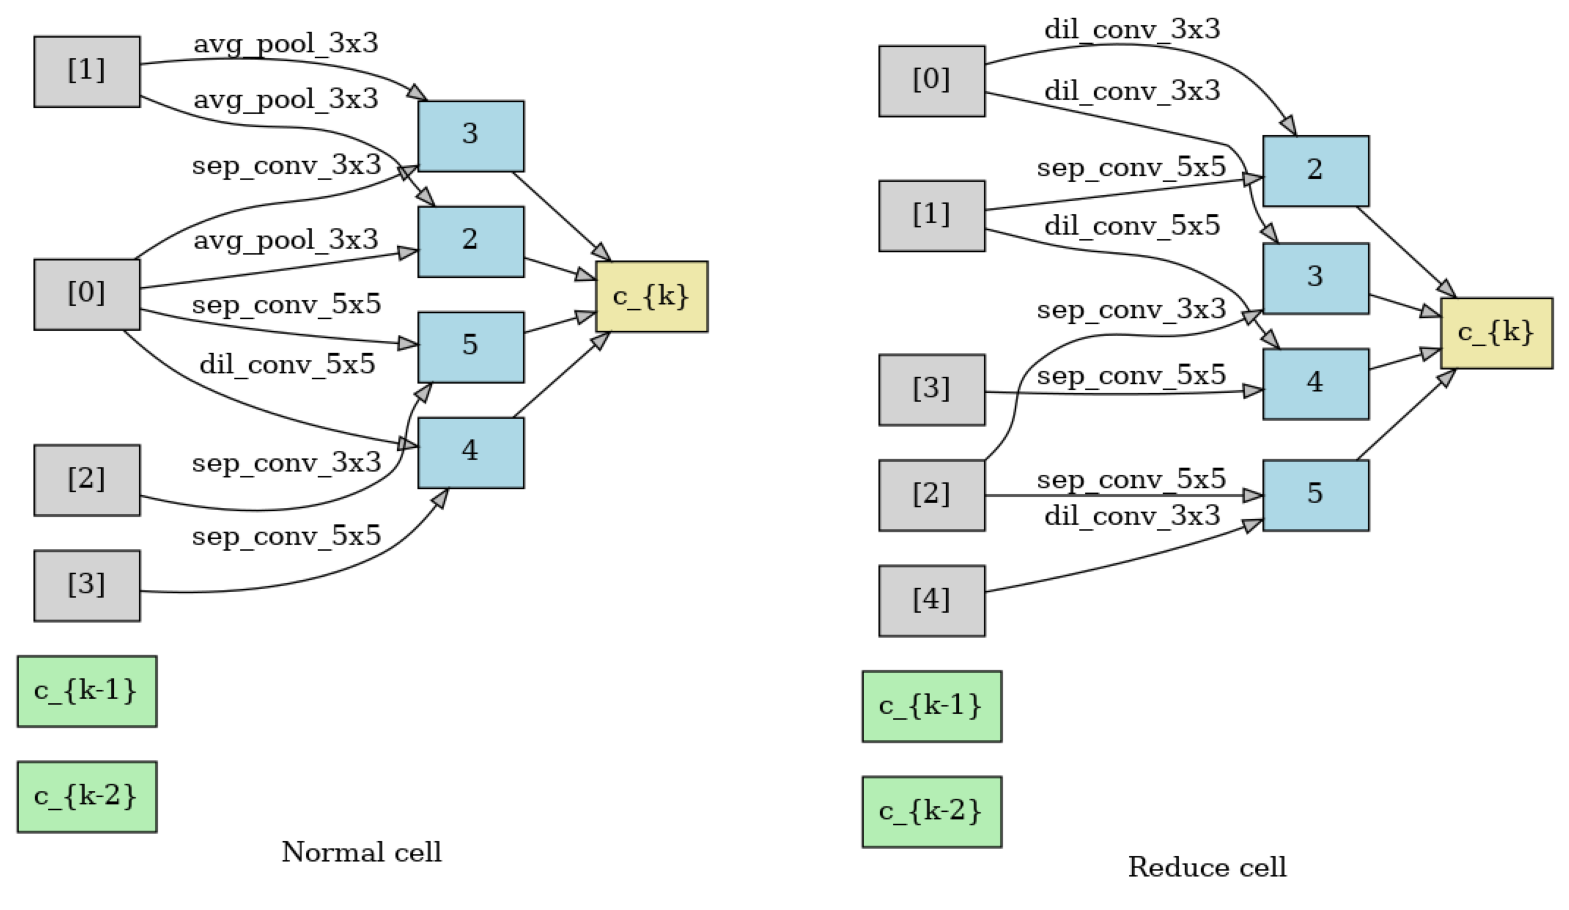

In [32]:
import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')
    assert len(arch_dict) % 2 == 0

    for i in range(2, 6):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, 6):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            if from_ == 0:
                u = 'c_{k-2}'
            elif from_ == 1:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, 6):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_double_cells(arch_dict):
    image1 = plot_single_cell(arch_dict, 'normal')
    image2 = plot_single_cell(arch_dict, 'reduce')
    height_ratio = max(image1.size[1] / image1.size[0], image2.size[1] / image2.size[0])
    _, axs = plt.subplots(1, 2, figsize=(20, 10 * height_ratio))
    axs[0].imshow(image1)
    axs[1].imshow(image2)
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

plot_double_cells(exported_arch)

Retrain the searched model

In [33]:
from nni.nas.space import model_context

with model_context(exported_arch):
    final_model = DartsSpace(width=16, num_cells=8, dataset='cifar')

In [34]:
train_loader = DataLoader(train_data, batch_size=96, num_workers=6)  # Use the original training data

In [35]:
valid_loader

In [36]:
max_epochs = 100

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
    max_epochs=max_epochs,
    num_classes=10,
    export_onnx=False,          # Disable ONNX export for this experiment
    fast_dev_run=True   # Should be false for fully training
)

evaluator.fit(final_model)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | metrics   | ModuleDict       | 0      | train
2 | _model    | DARTS            | 322 K  | train
-------------------------------------------------------
322 K     Trainable params
0         Non-trainable params
322 K     Total params
1.290     Total estimated model params size (MB)
625       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, train_loss=2.330, train_acc=0.0833, val_loss=2.310, val_acc=0.0781]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, train_loss=2.330, train_acc=0.0833, val_loss=2.310, val_acc=0.0781]
[2025-04-18 11:26:46] Final result: 0.078125


Reproduce results in DARTS paper

In [41]:
import torch
from nni.nas.evaluator.pytorch import ClassificationModule

class DartsClassificationModule(ClassificationModule):
    def __init__(
        self,
        learning_rate: float = 0.001,
        weight_decay: float = 0.,
        auxiliary_loss_weight: float = 0.4,
        max_epochs: int = 600,
        num_classes: int = 10,
    ):
        self.auxiliary_loss_weight = auxiliary_loss_weight
        # Training length will be used in LR scheduler
        self.max_epochs = max_epochs
        super().__init__(learning_rate=learning_rate, weight_decay=weight_decay, num_classes=num_classes, export_onnx=False)

    def configure_optimizers(self):
        """Customized optimizer with momentum, as well as a scheduler."""
        optimizer = torch.optim.SGD(
            self.parameters(),
            momentum=0.9,
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.max_epochs, eta_min=1e-3)
        }

    def training_step(self, batch, batch_idx):
        """Training step, customized with auxiliary loss."""
        x, y = batch
        if self.auxiliary_loss_weight:
            y_hat, y_aux = self(x)
            loss_main = self.criterion(y_hat, y)
            loss_aux = self.criterion(y_aux, y)
            self.log('train_loss_main', loss_main)
            self.log('train_loss_aux', loss_aux)
            loss = loss_main + self.auxiliary_loss_weight * loss_aux
        else:
            y_hat = self(x)
            loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        for name, metric in self.metrics.items():
            self.log('train_' + name, metric(y_hat, y), prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        # Set drop path probability before every epoch. This has no effect if drop path is not enabled in model.
        self.model.set_drop_path_prob(self.model.drop_path_prob * self.current_epoch / self.max_epochs)

        # Logging learning rate at the beginning of every epoch
        self.log('lr', self.trainer.optimizers[0].param_groups[0]['lr'])

In [42]:
from nni.nas.evaluator.pytorch import Lightning, Trainer

max_epochs = 50

evaluator = Lightning(
    DartsClassificationModule(0.025, 3e-4, 0., 10),
    Trainer(
        max_epochs=max_epochs,
        fast_dev_run=True,
    ),
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [43]:
strategy = DartsStrategy(gradient_clip_val=5.)

In [44]:
model_space = DartsSpace(width=16, num_cells=8, dataset='cifar')

experiment = NasExperiment(model_space, evaluator, strategy)
experiment.run()

exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

[2025-04-18 11:27:48] Config is not provided. Will try to infer.
[2025-04-18 11:27:48] Strategy is found to be a one-shot strategy. Setting execution engine to "sequential" and format to "raw".
[2025-04-18 11:27:48] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:48] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:48] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:50] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:50] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:50] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:50] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:50] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params | Mode 
----------------------------------------------------------------------
0 | training_module | DartsClassificationModule | 2.0 M  | train
----------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.950     Total estimated model params size (MB)
8031      Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.29it/s, train_loss=2.380, train_acc=0.0938]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.29it/s, train_loss=2.380, train_acc=0.0938]
[2025-04-18 11:27:56] Waiting for models submitted to engine to finish...
[2025-04-18 11:27:56] Experiment is completed.
[2025-04-18 11:27:56] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-18 11:27:56] Sorted weights in differentiable cell export (normal cell, node 2): [(0.0017427755519747734, 1, 'skip_connect'), (0.0008431246387772262, 0, 'avg_pool_3x3'), (0.0010487200925126672, 1, 'dil_conv_3x3'), (0.000903098494745791, 1, 'sep_conv_3x3'), (0.0007709934143349528, 0, 'dil_conv_5x5'), (0.00023542474082205445, 1, 'avg_pool_3x3'), (5.625989433610812e-05, 1, 'sep_conv_5x5'), (-3.238462159060873e-05, 0, 'sep_conv_5x5'), (-4.241177884978242e-05, 0, 'max_pool_3x3'), (-0.0005364671815186739, 0, 'sep_conv_3x3'), (-0.0010920559288933873, 1, 'dil_conv_5x5'), (-0.0012935572303831577, 0, 'dil_conv_3x3'), (-0.0016789463115856051, 1, 'max_pool_3x3'), (-0.0017973120557144

{'normal/op_2_0': 'skip_connect',
 'normal/input_2_0': [1],
 'normal/op_2_1': 'avg_pool_3x3',
 'normal/input_2_1': [0],
 'normal/op_3_0': 'skip_connect',
 'normal/input_3_0': [1],
 'normal/op_3_1': 'sep_conv_3x3',
 'normal/input_3_1': [2],
 'normal/op_4_0': 'avg_pool_3x3',
 'normal/input_4_0': [2],
 'normal/op_4_1': 'dil_conv_5x5',
 'normal/input_4_1': [1],
 'normal/op_5_0': 'sep_conv_3x3',
 'normal/input_5_0': [2],
 'normal/op_5_1': 'dil_conv_5x5',
 'normal/input_5_1': [4],
 'reduce/op_2_0': 'sep_conv_3x3',
 'reduce/input_2_0': [1],
 'reduce/op_2_1': 'dil_conv_5x5',
 'reduce/input_2_1': [0],
 'reduce/op_3_0': 'dil_conv_3x3',
 'reduce/input_3_0': [2],
 'reduce/op_3_1': 'dil_conv_5x5',
 'reduce/input_3_1': [1],
 'reduce/op_4_0': 'max_pool_3x3',
 'reduce/input_4_0': [2],
 'reduce/op_4_1': 'max_pool_3x3',
 'reduce/input_4_1': [3],
 'reduce/op_5_0': 'sep_conv_3x3',
 'reduce/input_5_0': [3],
 'reduce/op_5_1': 'sep_conv_5x5',
 'reduce/input_5_1': [0]}

In [ ]:
import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')
    assert len(arch_dict) % 2 == 0

    for i in range(2, 6):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, 6):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            if from_ == 0:
                u = 'c_{k-2}'
            elif from_ == 1:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, 6):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_double_cells(arch_dict):
    image1 = plot_single_cell(arch_dict, 'normal')
    image2 = plot_single_cell(arch_dict, 'reduce')
    height_ratio = max(image1.size[1] / image1.size[0], image2.size[1] / image2.size[0])
    _, axs = plt.subplots(1, 2, figsize=(20, 10 * height_ratio))
    axs[0].imshow(image1)
    axs[1].imshow(image2)
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

plot_double_cells(exported_arch)

In [45]:
def cutout_transform(img, length: int = 16):
    h, w = img.size(1), img.size(2)
    mask = np.ones((h, w), np.float32)
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - length // 2, 0, h)
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)

    mask[y1: y2, x1: x2] = 0.
    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img *= mask
    return img

transform_with_cutout = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    cutout_transform,
])

In [46]:
train_data_cutout = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform_with_cutout)
train_loader_cutout = DataLoader(train_data_cutout, batch_size=96)

In [47]:
with model_context(exported_arch):
    final_model = DartsSpace(width=36, num_cells=20, dataset='cifar', auxiliary_loss=True, drop_path_prob=0.2)

In [50]:
max_epochs = 30

evaluator = Lightning(
    DartsClassificationModule(0.025, 3e-4, 0.4, 10),
    trainer=Trainer(
        gradient_clip_val=5.,
        max_epochs=max_epochs,
        fast_dev_run=fast_dev_run
    ),
    train_dataloaders=train_loader_cutout,
    val_dataloaders=valid_loader,
)

evaluator.fit(final_model)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | metrics   | ModuleDict       | 0      | train
2 | _model    | DARTS            | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.972    Total estimated model params size (MB)
1520      Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 521/521 [02:18<00:00,  3.77it/s, v_num=9, train_loss=1.220, train_acc=0.675, val_loss=0.326, val_acc=0.894]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 521/521 [02:18<00:00,  3.76it/s, v_num=9, train_loss=1.220, train_acc=0.675, val_loss=0.326, val_acc=0.894]
[2025-04-18 15:25:37] Final result: 0.8938999772071838
